In [2]:
import pandas as pd
import numpy as np
from libV2 import IIR_highpass, IIR
import matplotlib.pyplot as plt
from dataset import ScalerTypes
from libV2 import minMaxScale, standardScale
import joblib
from libV2 import split_sequence


2024-05-20 22:27:56.678097: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 22:27:56.678239: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 22:27:56.678287: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 22:27:56.697274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from typing import List


def fill_na_mean(df, target_columns: List):
    frame = df.copy()
    # per ogni colonna target sostituisco i valori nan
    for idx, c in enumerate(target_columns):
        # trovo le posizioni dei nan
        # alcuni valori non hanno nan, come ad esempio le date, per loro viene generata un'eccezione
        # e quindi si passa alla colonna successiva
        try:
            zero_pos = frame[np.isnan(frame[c].values)].index
            for zp in zero_pos:
                # primo valore precedente allo zero
                v0 = np.mean(frame[c])
                v1 = v0
                if zp > 0:
                    # prendo l'ultimo valore diverso da nan prima della posizione dello zero
                    v0 = frame[:zp].values[~np.isnan(frame[c].values[:zp])][-1, idx]
                # primo valore successivo allo zero
                if zp < len(df):
                    # prendo il primo valore diverso da nan dopo la posizione dello zero
                    v1 = frame[zp:].values[~np.isnan(frame[c].values[zp:])][0, idx]
                frame.at[zp, c] = (v0 + v1) / 2
        except Exception as e:
            print(f'{c}: {e}')
            pass
    return frame


In [4]:
def scale_df(frame, columns_to_scale=None, scaler_names=None,
             scalerType: ScalerTypes = ScalerTypes.MINMAX):
    if columns_to_scale is None:
        print('No columns to scale')
        return
    frame = frame.copy()
    if scaler_names:
        # ho già gli scalers, li carico e li utilizzo
        scalers = []
        for scaler_name in scaler_names:
            scalers.append(joblib.load(scaler_name))
        for idx, cts in enumerate(columns_to_scale):
            frame[cts] = scalers[idx].transform(
                frame[cts].values.reshape(-1, 1).astype('float64'))
    else:
        # creo gli scalers in base al tipo e li salvo
        for cts in columns_to_scale:
            if scalerType == ScalerTypes.MINMAX:
                tmp_scaler = minMaxScale(frame, cts)
            else:
                tmp_scaler = standardScale(frame, cts)
            # salvo lo scaler
            joblib.dump(tmp_scaler, f'train-scalers/{cts}_scaler.save')
    return frame

In [5]:
columns = ['date', 'RSAM', 'T_olb', 'Ru_olb', 'P_olb', 'Rn_olb', 'T_msa',
               'Ru_msa', 'P_msa', 'Rn_msa', 'displacement (cm)',
               'background seismicity']
columns_to_scale = ['RSAM', 'T_olb', 'Ru_olb', 'P_olb', 'Rn_olb']
columns_to_forecast = ['Rn_olb']
columns_to_drop=['date', 'displacement (cm)','background seismicity','T_msa','Ru_msa', 'P_msa', 'Rn_msa']



In [10]:
df = pd.read_csv('data/train.csv')
df.columns = columns


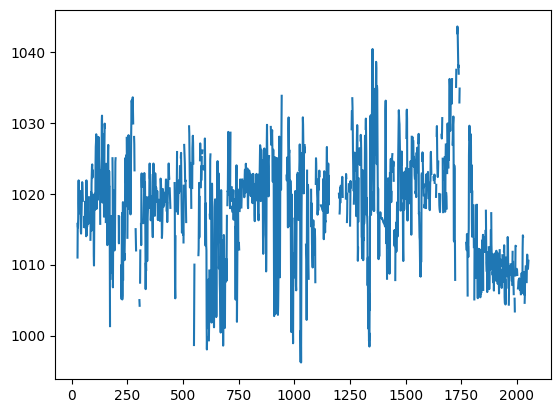

In [11]:
plt.plot(df['P_olb'])

In [12]:
np.mean(df['P_olb'])

1018.394516011153

In [13]:
na_cols = np.isnan(df[columns_to_forecast[0]].values)
df = df.assign(na_cols=na_cols)
df = fill_na_mean(df,columns)

date: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
displacement (cm): index 0 is out of bounds for axis 0 with size 0
background seismicity: index 0 is out of bounds for axis 0 with size 0


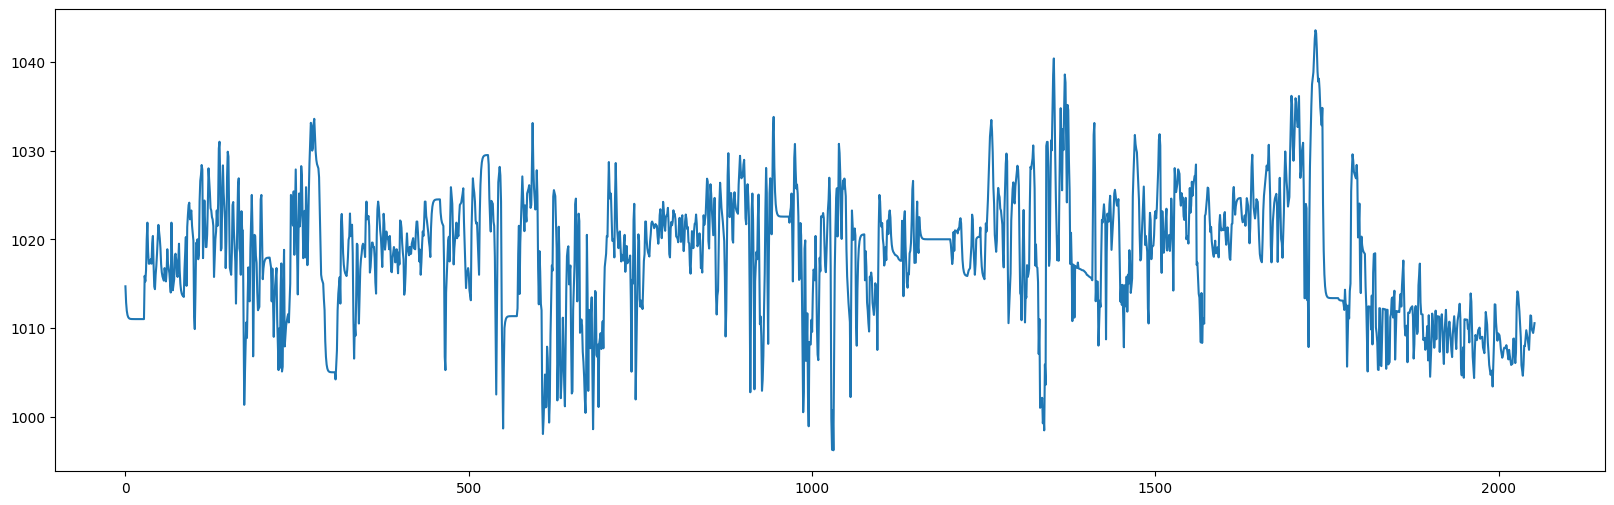

In [99]:
plt.figure(figsize=(20,6))
plt.plot(df['P_olb'])

In [100]:

columns_to_filter = ['RSAM', 'Rn_olb']
filters = [IIR_highpass for i in range(len(columns_to_filter))]
frame = IIR(df, target_columns=columns_to_filter, filters=filters)
filtered_names = []
for c in columns_to_filter:
    filtered_name = f'filtered_{c}'
    frame[c] = frame[filtered_name]
    filtered_names.append(filtered_name)
frame.drop(columns=filtered_names, inplace=True)

In [101]:

frame = scale_df(frame, scaler_names=None, columns_to_scale=columns_to_scale,
                              scalerType=ScalerTypes.STD)

In [102]:
frame

,date,RSAM,T_olb,Ru_olb,P_olb,Rn_olb,T_msa,Ru_msa,P_msa,Rn_msa,displacement (cm),background seismicity,na_cols
0,2011-07-04 00:00:00.000,-0.019076,0.244428,0.036216,-0.493888,0.001841,29.671118,61.955425,1037.680503,15253.667377,16.241425,111.250000,True
1,2011-07-05 00:00:00.000,0.043225,0.388951,0.092876,-0.752988,-0.162161,30.452226,61.416556,1034.673585,13801.624143,12.659712,90.625000,True
2,2011-07-06 00:00:00.000,-0.167275,0.461212,0.121206,-0.882539,-0.211361,30.842780,61.147121,1033.170126,13075.602526,9.078000,80.312500,True
3,2011-07-07 00:00:00.000,-0.463392,0.497343,0.135371,-0.947314,-0.209721,31.038056,61.012404,1032.418396,12712.591717,9.215500,75.156250,True
4,2011-07-08 00:00:00.000,-0.270563,0.515408,0.142453,-0.979701,-0.187909,31.135695,60.945045,1032.042531,12531.086313,9.284250,72.578125,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048,2016-08-29 00:00:00.000,-0.383698,1.283657,1.252975,-1.171397,0.141157,38.285547,64.687958,1045.523193,10361.998909,NaN,234.968750,False
2049,2016-08-29 15:45:40.550,-0.187403,1.300535,1.180775,-1.201433,0.169166,38.285547,64.687958,1045.523193,10361.998909,NaN,235.000000,True
2050,2016-08-30 00:00:00.000,-0.030367,1.317414,1.108574,-1.231470,0.191573,38.285547,64.687958,1045.523193,10361.998909,NaN,NaN,False
2051,2016-08-31 00:00:00.000,3.359532,1.282489,1.411378,-1.162593,-0.210398,36.060547,64.162958,1045.648193,14012.672421,NaN,NaN,False


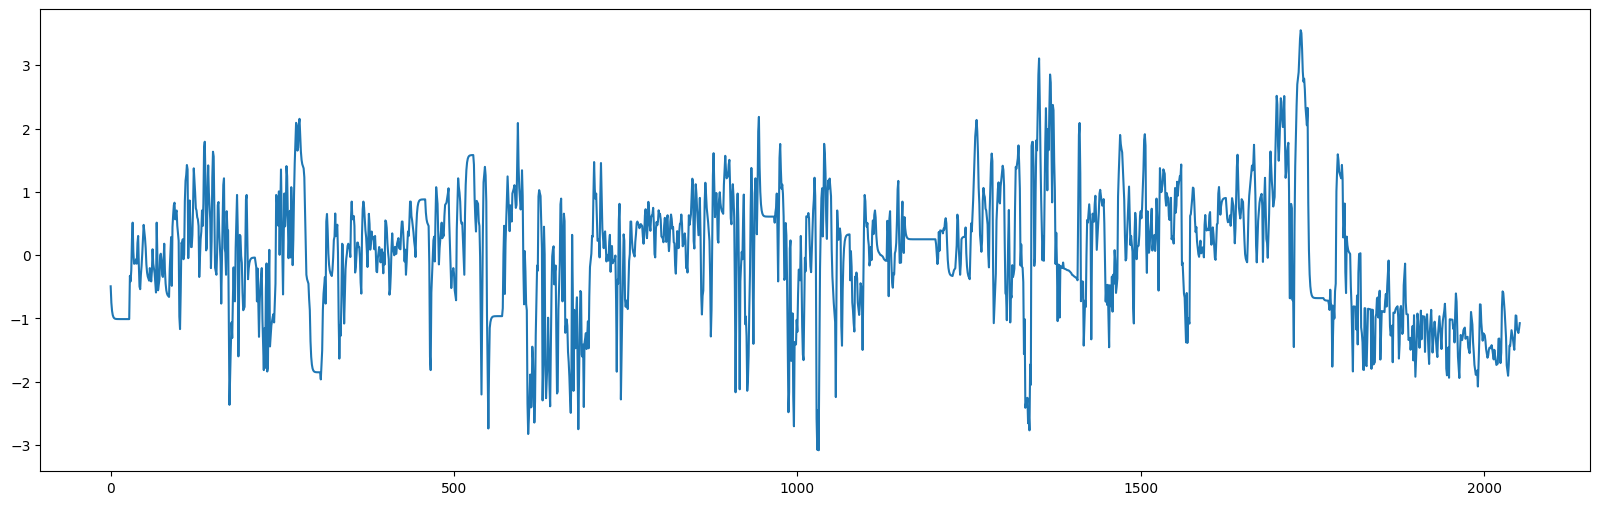

In [105]:
plt.figure(figsize=(20,6))
plt.plot(frame['P_olb'])

In [106]:
frame_drop = frame.drop(columns_to_drop, axis=1)

In [107]:
frame_drop

,RSAM,T_olb,Ru_olb,P_olb,Rn_olb,na_cols
0,-0.019076,0.244428,0.036216,-0.493888,0.001841,True
1,0.043225,0.388951,0.092876,-0.752988,-0.162161,True
2,-0.167275,0.461212,0.121206,-0.882539,-0.211361,True
3,-0.463392,0.497343,0.135371,-0.947314,-0.209721,True
4,-0.270563,0.515408,0.142453,-0.979701,-0.187909,True
...,...,...,...,...,...,...
2048,-0.383698,1.283657,1.252975,-1.171397,0.141157,False
2049,-0.187403,1.300535,1.180775,-1.201433,0.169166,True
2050,-0.030367,1.317414,1.108574,-1.231470,0.191573,False
2051,3.359532,1.282489,1.411378,-1.162593,-0.210398,False


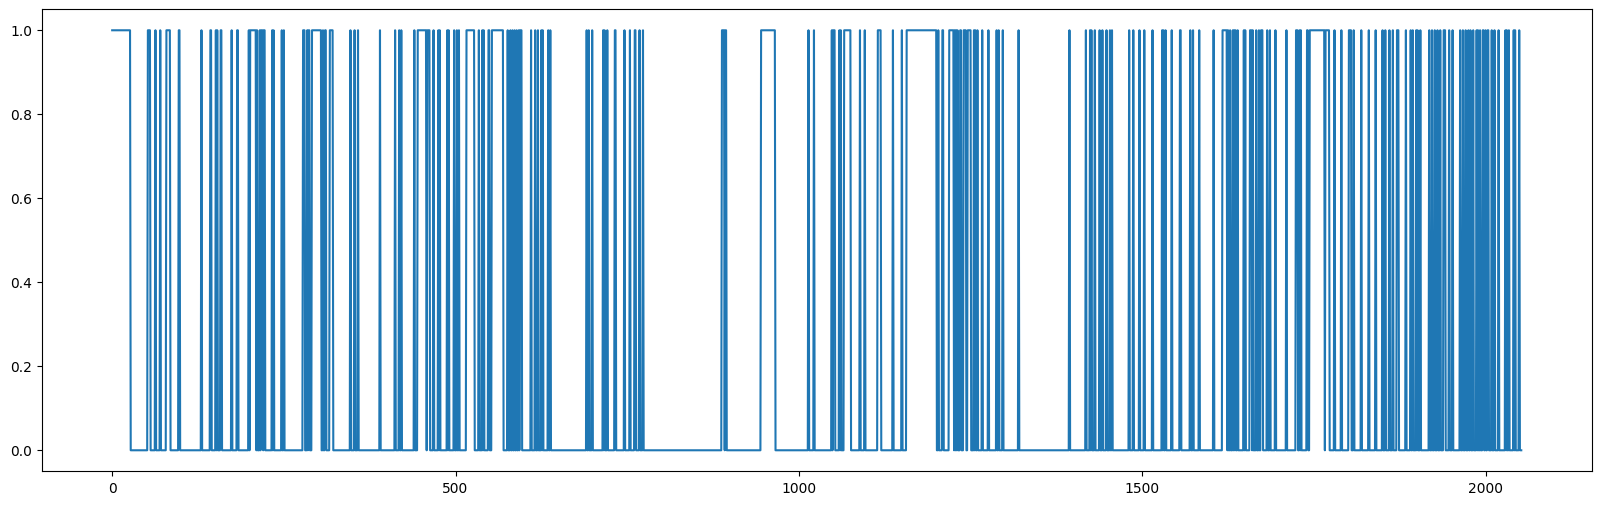

In [108]:
plt.figure(figsize=(20,6))
plt.plot(frame_drop['na_cols'])

In [109]:
X, Y, ind_X, ind_Y = split_sequence(frame_drop.values, 30,1)


In [110]:
ctfs = [list(frame_drop.columns).index(ctf) for ctf in columns_to_forecast]
Y = Y[:, :, ctfs]

In [111]:
frame_drop[31:61]

,RSAM,T_olb,Ru_olb,P_olb,Rn_olb,na_cols
31,-0.073474,0.610847,0.340344,0.249335,-0.815356,False
32,-0.149204,0.667265,0.615332,0.512131,-0.945510,False
33,-0.002027,0.675324,0.596813,0.056617,-0.441827,False
34,0.057298,0.731742,0.724767,-0.136100,-0.361121,False
35,-0.019353,0.739802,0.482328,-0.136100,-0.077799,False
36,-0.040817,0.780101,0.522734,-0.118581,-0.057211,False
37,0.015161,0.804280,0.547988,-0.066021,-0.063852,False
38,0.057214,0.804280,0.657422,-0.136100,-0.092386,False
39,0.190190,0.804280,0.691095,0.189267,-0.451780,False
40,0.141244,0.804280,0.724767,0.301894,-0.586037,False


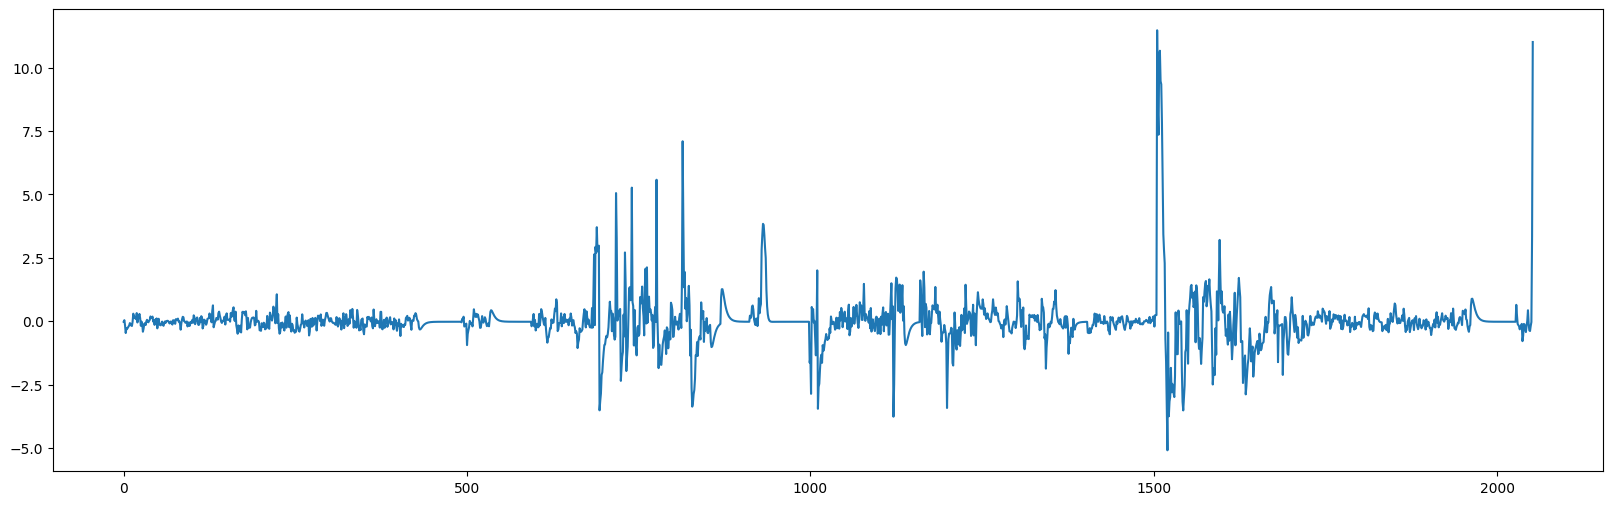

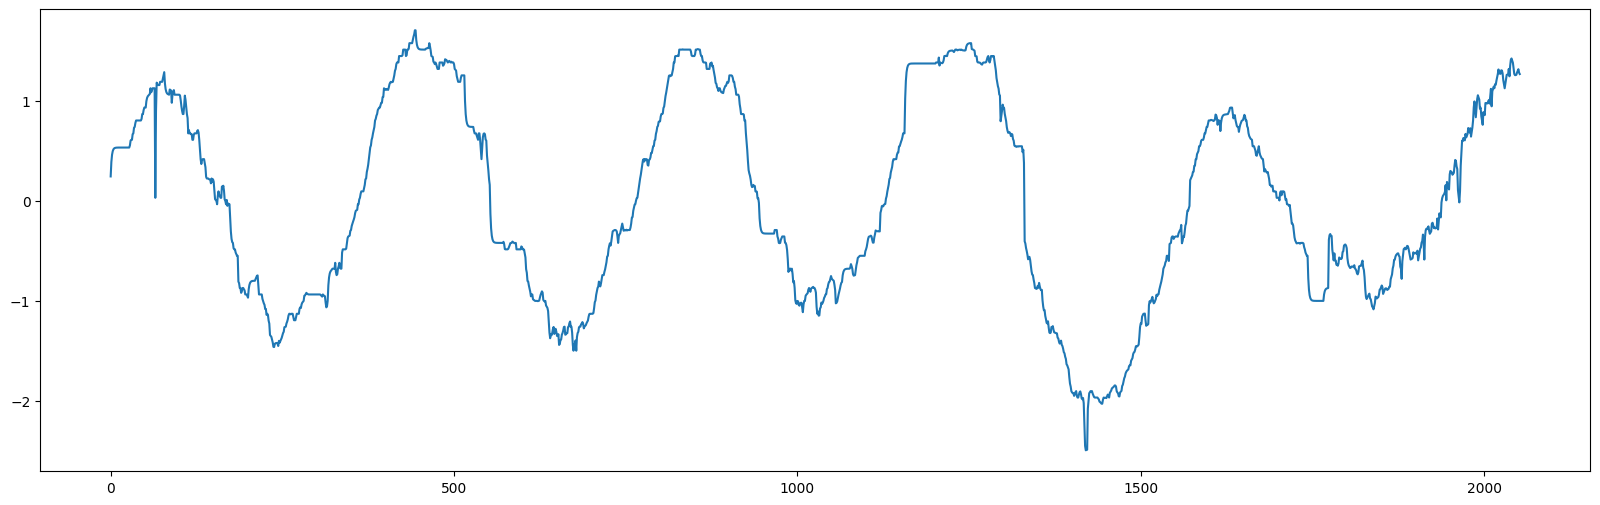

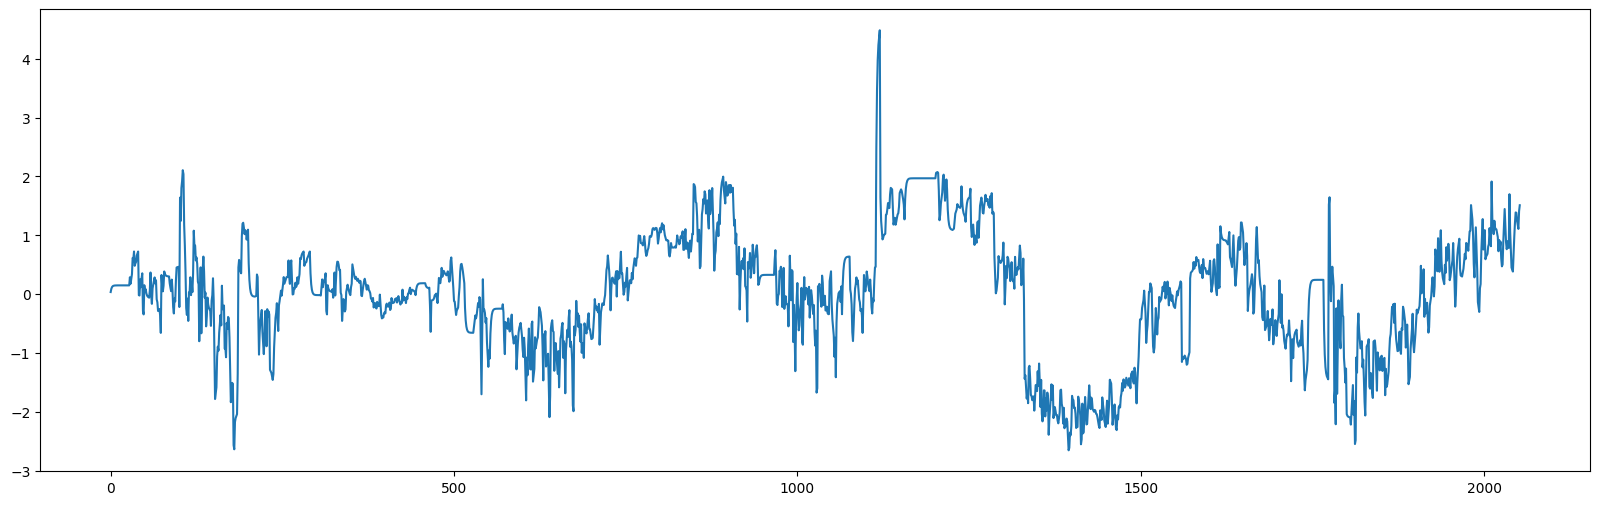

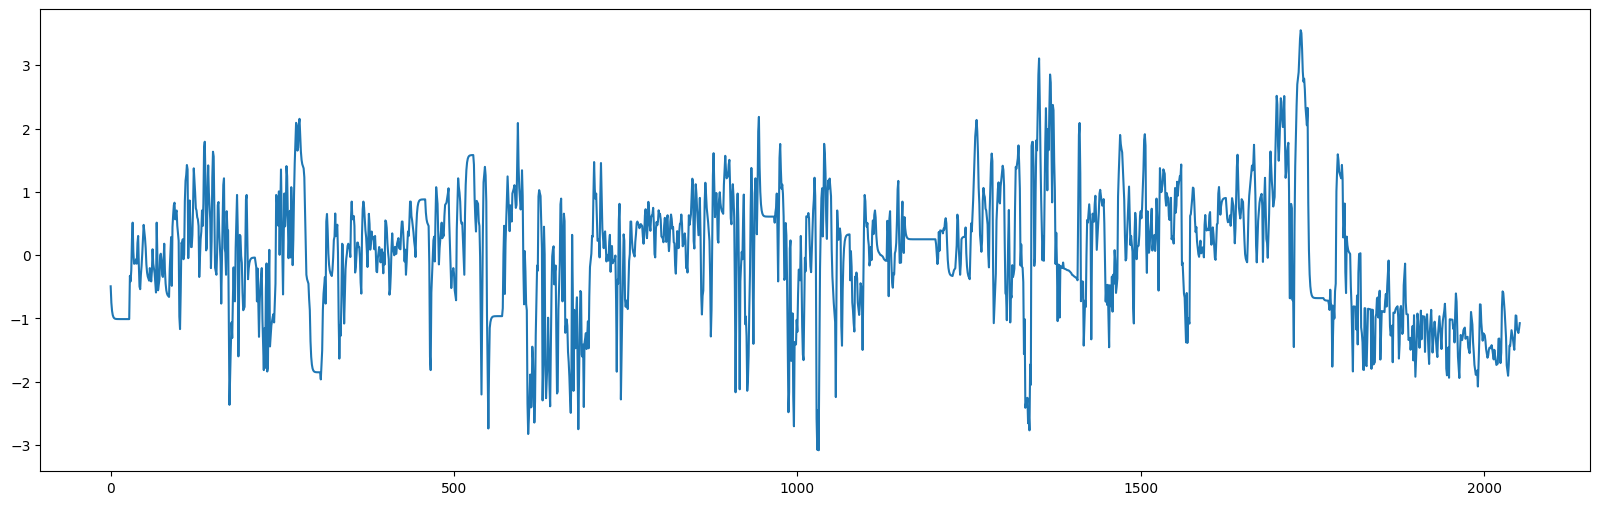

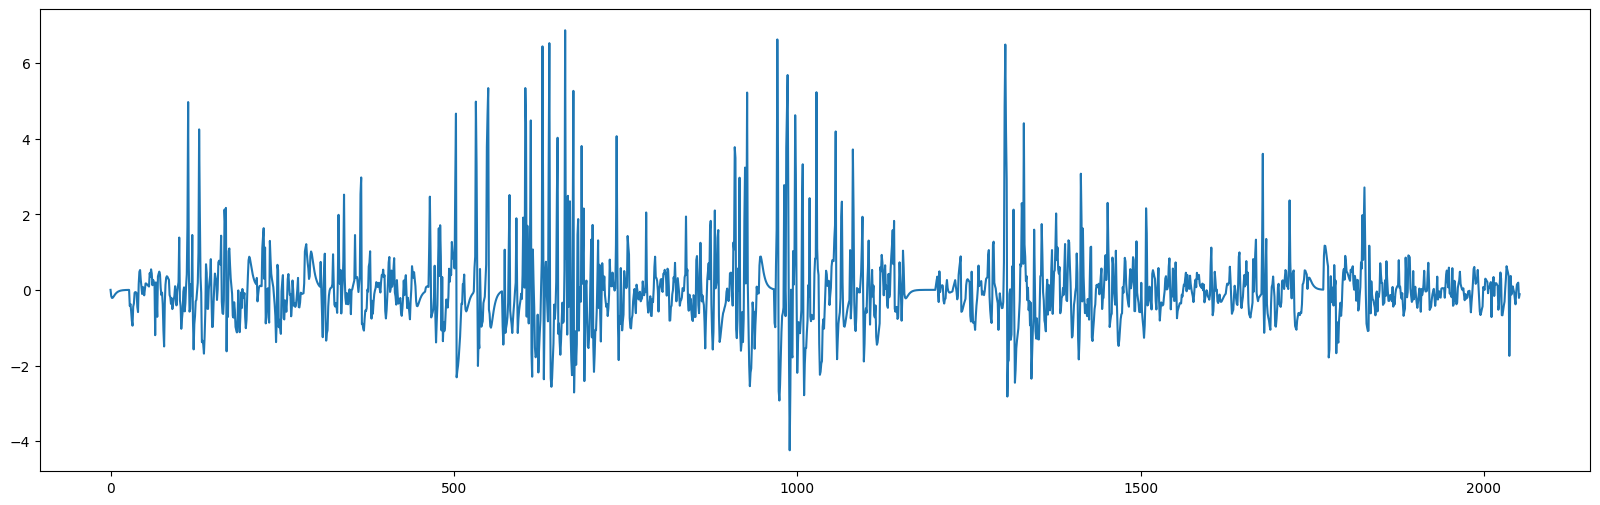

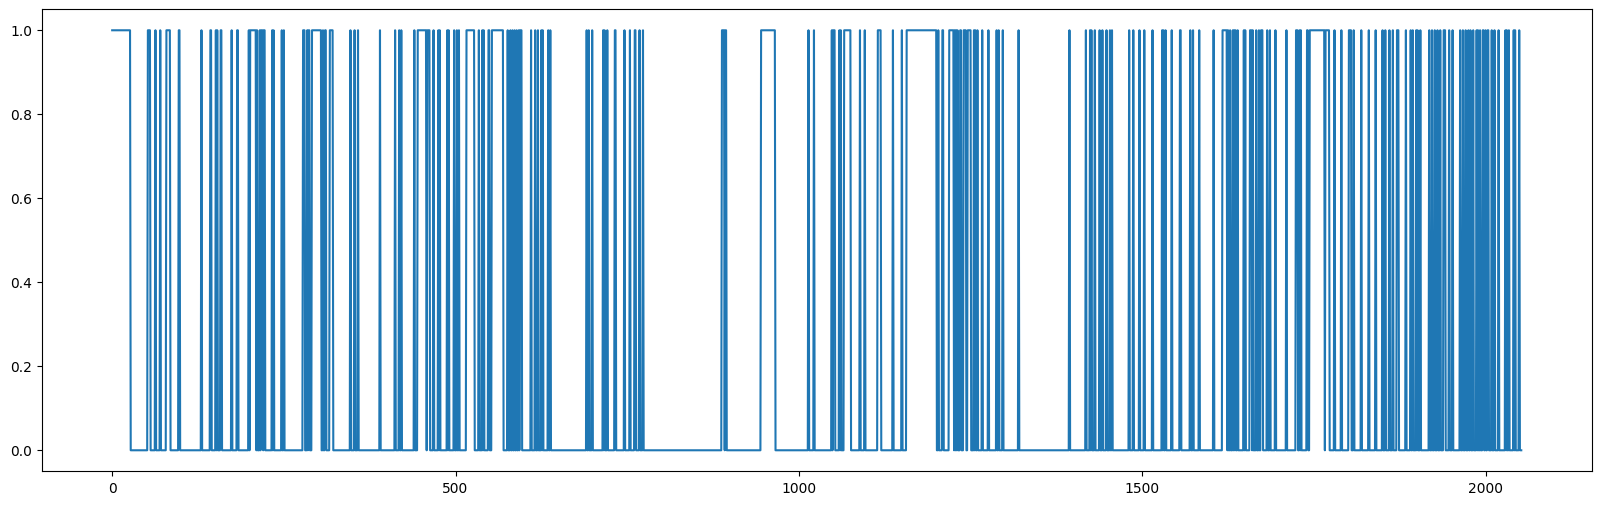

In [112]:
for c in frame_drop.columns:
    plt.figure(figsize=(20,6))
    plt.plot(range(len(frame_drop[c])),frame_drop[c])

In [113]:
X[0]

array([[-0.01907612835379298, 0.24442777163445858, 0.03621644944742111,
        -0.4938879510975324, 0.00184092088007708, True],
       [0.04322453076636913, 0.388950755523861, 0.09287597932952009,
        -0.7529884265440365, -0.162160748571138, True],
       [-0.16727546497462775, 0.4612122474685611, 0.12120574427056958,
        -0.8825386642672965, -0.21136124940650264, True],
       [-0.46339163628713337, 0.4973429934409111, 0.1353706267411039,
        -0.9473137831289186, -0.20972123271199034, True],
       [-0.2705634062873581, 0.5154083664270861, 0.14245306797637106,
        -0.9797013425597216, -0.18790901067497878, True],
       [-0.2975245503620742, 0.5244410529201747, 0.14599428859399508,
        -0.9958951222751311, -0.1602091287046689, True],
       [-0.25728362434616053, 0.528957396166718, 0.14776489890281663,
        -1.0039920121328438, -0.13292417095807033, True],
       [-0.2074701171747383, 0.5312155677899896, 0.14865020405722743,
        -1.008040457061692, -0.10853

In [114]:
frame_drop

,RSAM,T_olb,Ru_olb,P_olb,Rn_olb,na_cols
0,-0.019076,0.244428,0.036216,-0.493888,0.001841,True
1,0.043225,0.388951,0.092876,-0.752988,-0.162161,True
2,-0.167275,0.461212,0.121206,-0.882539,-0.211361,True
3,-0.463392,0.497343,0.135371,-0.947314,-0.209721,True
4,-0.270563,0.515408,0.142453,-0.979701,-0.187909,True
...,...,...,...,...,...,...
2048,-0.383698,1.283657,1.252975,-1.171397,0.141157,False
2049,-0.187403,1.300535,1.180775,-1.201433,0.169166,True
2050,-0.030367,1.317414,1.108574,-1.231470,0.191573,False
2051,3.359532,1.282489,1.411378,-1.162593,-0.210398,False


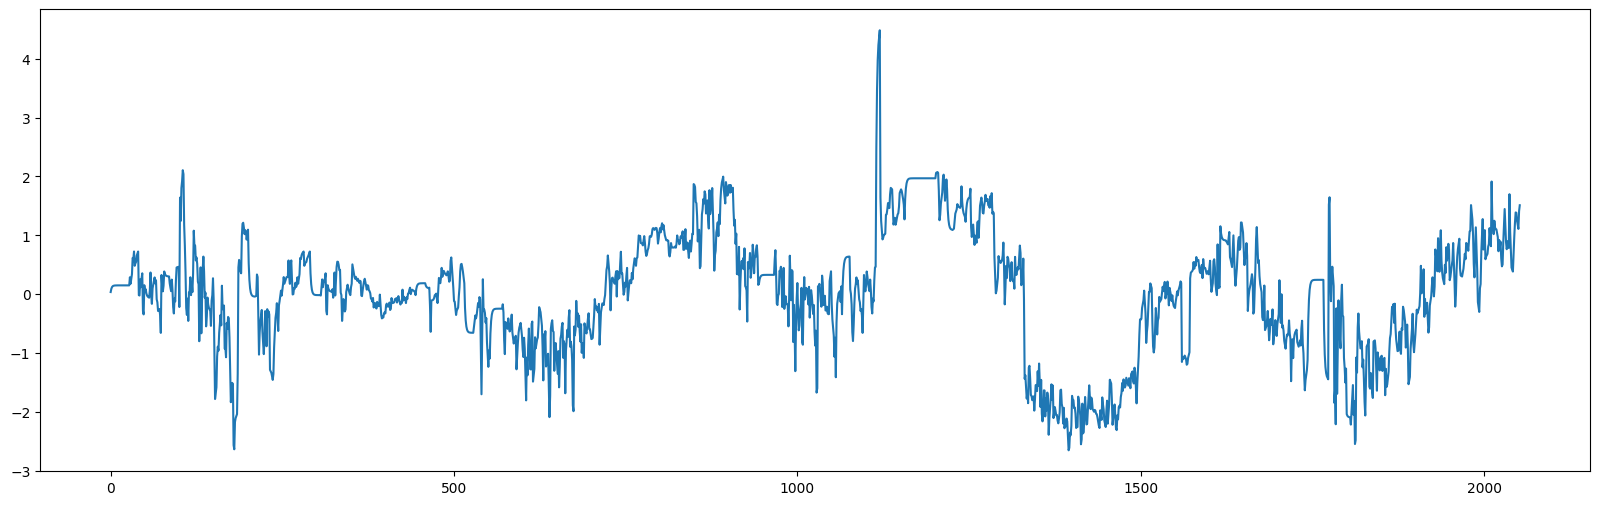

In [117]:
plt.figure(figsize=(20,6))
plt.plot(frame_drop['Ru_olb'])